In [1]:
import time

import matplotlib
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def data_collect():
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome("C:/Users/yuval/PycharmProjects/Data-science-Weather/chromedriver/chromedriver")#, options=chrome_options)
    df = pd.DataFrame([], columns=["year", "month", "day", "temp", "humidity", "windspeed", "precipitation"])
    df_row_count=1

    # switch temp from fahrenheit to celsius
    driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/2000-1")
    settings = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "wuSettings")))
    settings.click()
    time.sleep(2)
    celsius = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH,
                                                                              '//*[@id="wuSettings-quick"]/div/a[2]')))
    celsius.click()

    for year in range(2000,2023):
        for month in range(1,13):
            driver.get(f"https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/{year}-{month}")
            try:
                table_id= WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "days")))
                data = table_id.find_elements(By.TAG_NAME, "table") # get all of the rows in the table
                num_of_days = len(data[1].find_elements(By.TAG_NAME, "tr"))

                for i in range(1,num_of_days):
                    day = int(data[0].find_elements(By.TAG_NAME, "tr")[i].text)
                    temp = float(data[1].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    humidity = float(data[3].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    windspeed = float(data[4].find_elements(By.TAG_NAME, "tr")[i].text.split(' ')[1])
                    precipitation = float(data[6].find_elements(By.TAG_NAME, "tr")[i].text)
                    day_data = [year,month,day,temp,humidity,windspeed,precipitation]
                    df.loc[df_row_count] = day_data
                    df_row_count += 1
            except Exception as e:
                print(f"cloud not get {year}-{month} data: {e}")

    driver.quit()
    df.to_csv('~/Documents/nyc_weather.csv',index=False) #for debugging
    return df

In [3]:
def normalize_data(data_df, good_weather_values):
    norm_df = data_df.copy()

    for i in norm_df.columns:
        if i not in ['year', 'month', 'day']:
            good_min = good_weather_values[i][0]
            good_max = good_weather_values[i][1]
            diff_min = good_weather_values[i][0] - norm_df[i].min()
            diff_max = norm_df[i].max() - good_weather_values[i][1]
            norm_df.loc[(norm_df[i] < good_min), i] = 1 - ((good_min - norm_df[i]) / diff_min)
            norm_df.loc[(norm_df[i] > good_max), i] = 1 - ((norm_df[i] - good_max) / diff_max)
            norm_df.loc[(norm_df[i] <= good_max) & (norm_df[i] >= good_min), i] = 1
    norm_df.insert(7, "pleasant day", 0)
    norm_df.loc[(norm_df["temp"] > 0),"pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"] + norm_df["precipitation"]) / 4
    norm_df.loc[(norm_df["temp"] > 0) & (norm_df["precipitation"].isna()), "pleasant day"] = (norm_df["temp"] + norm_df["humidity"] + norm_df["windspeed"]) / 3

    # norm_df.to_csv('~/Documents/nyc_weather_norm.csv', index=False)  # for debugging

    return norm_df

In [4]:
def remove_missing_data(data):
    data.loc[data["year"] <= 2014, "precipitation"] = np.NaN
    return data

In [31]:
def num_of_good_days_per_month(data):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for i in range(0,12):
        res[months[i]] = len(data.loc[(data['month'] == (i+1)) & (data['pleasant day'] >= 0.9)])
    ser = pd.Series(res)
    print(ser)
    ser.plot(kind='pie', ax=axes)

In [36]:
def num_of_good_days_trends(data):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    months=['Jan', 'Feb','Mar','Apr','May','jun','Jul','Aug','Sep','Oct','Nov','Dec']
    res = {}
    for j in range(2000,2023):
        for i in range(0,12):
            res[months[f"{i}-{j}"]] = round(data.loc[(data['month'] == (i+1)) & (data['year'] == j)].mean(),2)
    print(res)
    #ser.plot(kind='line', ax=axes)

Jan     11
Feb     21
Mar     81
Apr    249
May    326
jun    314
Jul    253
Aug    277
Sep    330
Oct    258
Nov    119
Dec     24
dtype: int64


TypeError: list indices must be integers or slices, not str

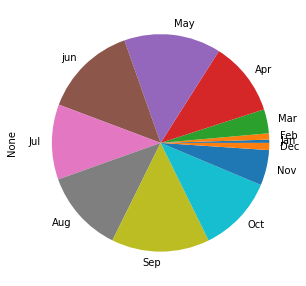

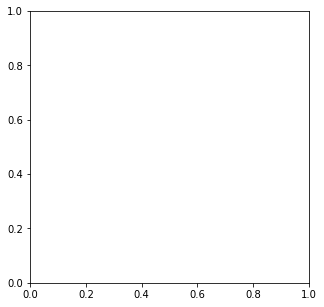

In [38]:
if __name__ == '__main__':
    # nice weather:
    # temp 18-25
    # humidity 30-50%
    # windspeed 0-7
    # precipitation 0 - 0.5
    good_weather_values = {'temp': [18,25], 'humidity':[30,50],'windspeed':[4,20], 'precipitation':[0,1]}
    # df = data_collect()
    df = pd.read_csv('~/Documents/nyc_weather.csv') # for debugging
    fixed_data = remove_missing_data(df)
    norm_df = normalize_data(fixed_data, good_weather_values)
    num_of_good_days_per_month(norm_df)
    num_of_good_days_trends(norm_df)